# BIOEE 4940 : **Introduction to Quantitative Analysis in Ecology**
### ***Spring 2021***
### Instructor: **Xiangtao Xu** ( ✉️ xx286@cornell.edu)
### Teaching Assistant: **Yanqiu (Autumn) Zhou** (✉️ yz399@cornell.edu)

---

## <span style="color:royalblue">Homework 3</span> *Landscape Heterogeneity in Tropical Dry Forests*




In this assignment, we will move from temperate forests to tropical dry forests, where there is large spatial heterogeneity due to both abotic (e.g. land type) and biotic (e.g. phenological diversity).

Here is an image from Google Earth showing the heterogeneity (different landcover types) in the Palo Verde National Park in the west of Costa Rica.

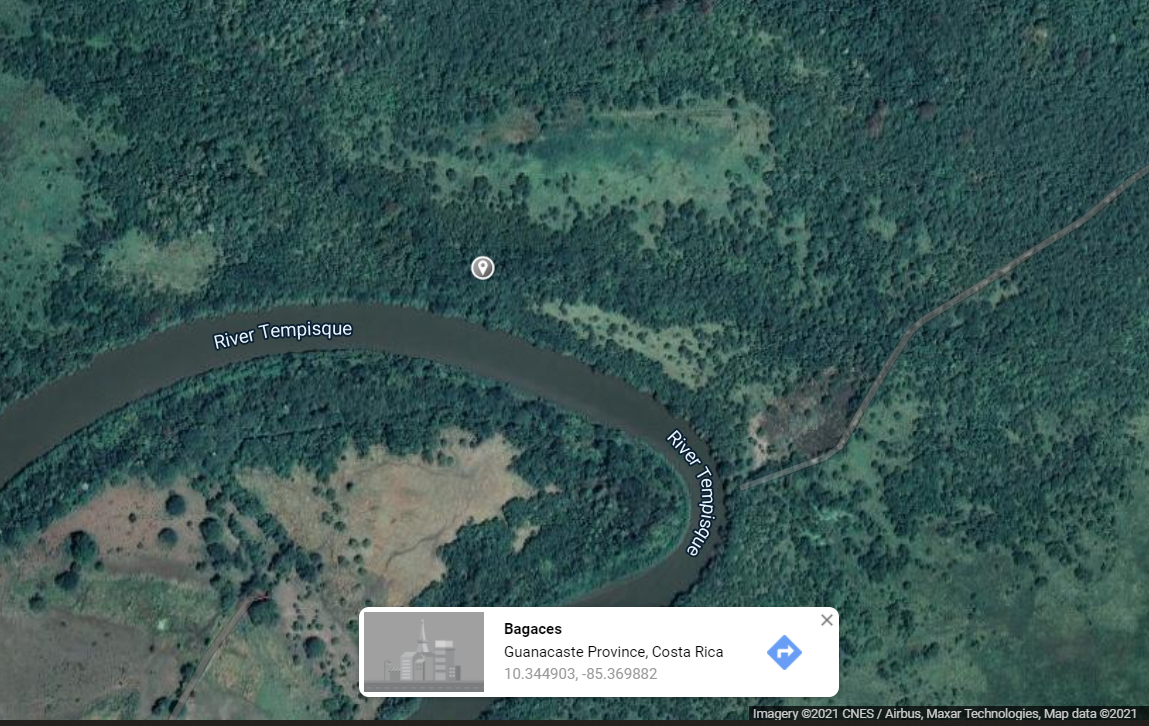

Specifically, we will work with high-resolution remote sensing data from Sentinel-2 Satellite (10m resolution) to assess the heterogeneity in a ~ 250m by 250m landscape (Data organized in csv files, refer to the Appendix at the end if you are interested in how the data was prepared).

Before we start, I am showing you in below the different images (RGB composites) from dry season (Apr) and wet season (Oct) in 2019 to showcase the drastic seasonal changes

In [ ]:
# Sentinel data acquisition from GEE
import ee

try:
    ee.Initialize()
except:
    # need to authenticate with your credential at the first time
    ee.Authenticate()
    ee.Initialize()
#import geemap 
import geemap.eefolium as geemap

# to get day number for each month
from calendar import monthrange


# lat and lon for a random place at Palo Verde National Park, Costa Rica
loc = [10.3450, -85.3705]

# identify a 1km buffer around our Point Of Interest (POI)
poi = ee.Geometry.Point(loc[1],loc[0]).buffer(200)


# get Sentinel data
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask1 = (qa.bitwiseAnd(cloudBitMask).eq(0))
    mask2 = (qa.bitwiseAnd(cirrusBitMask).eq(0))
    mask = mask1.bitwiseAnd(mask2)

    return image.updateMask(mask).divide(10000)

In [ ]:
image = (
    ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterDate('2019-04-01','2019-04-30')
                  .filterBounds(poi)                      
                  .map(maskS2clouds)
                  .median()
                  .clip(poi.bounds())
)

# Display the map.
visualization = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2'],
}

Map = geemap.Map(center=loc, zoom=20)

Map.addLayer(image, visualization, 'Sentinel 2 Dry season')

Map

(back-up image if the geemap does not work)
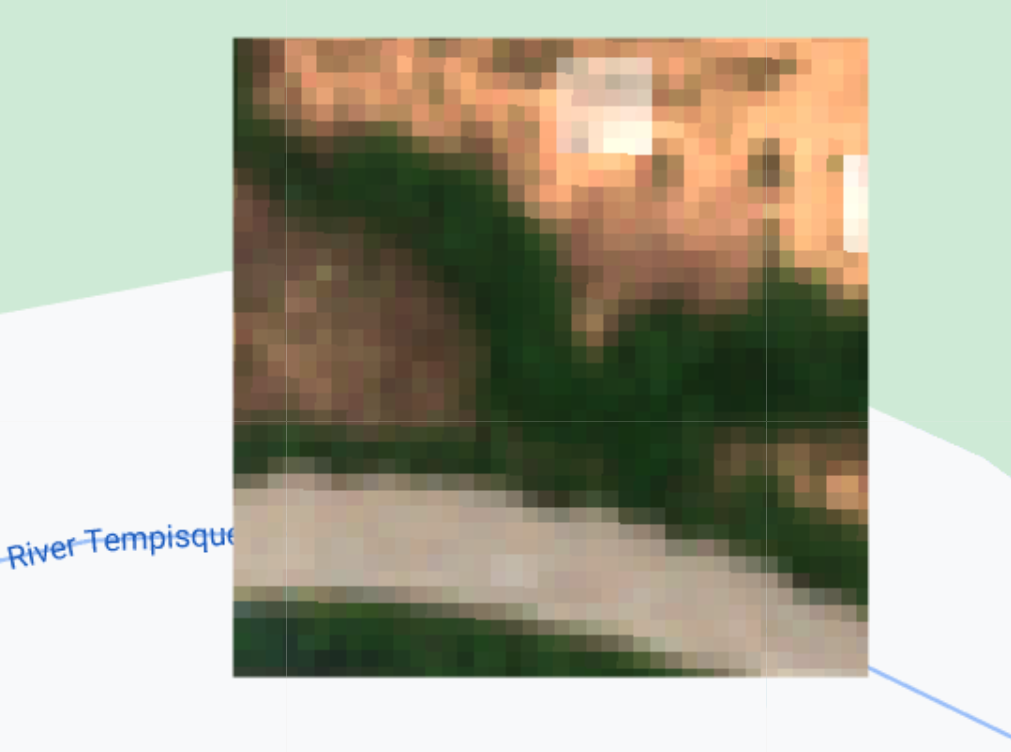

In [ ]:
image = (
    ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterDate('2019-10-01','2019-10-30')
                  .filterBounds(poi)                      
                  .map(maskS2clouds)
                  .median()
                  .clip(poi.bounds())
)

# Display the map.
visualization = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2'],
}

Map = geemap.Map(center=loc, zoom=20)

Map.addLayer(image, visualization, 'Sentinel 2 Wet season')

Map

(backup image)
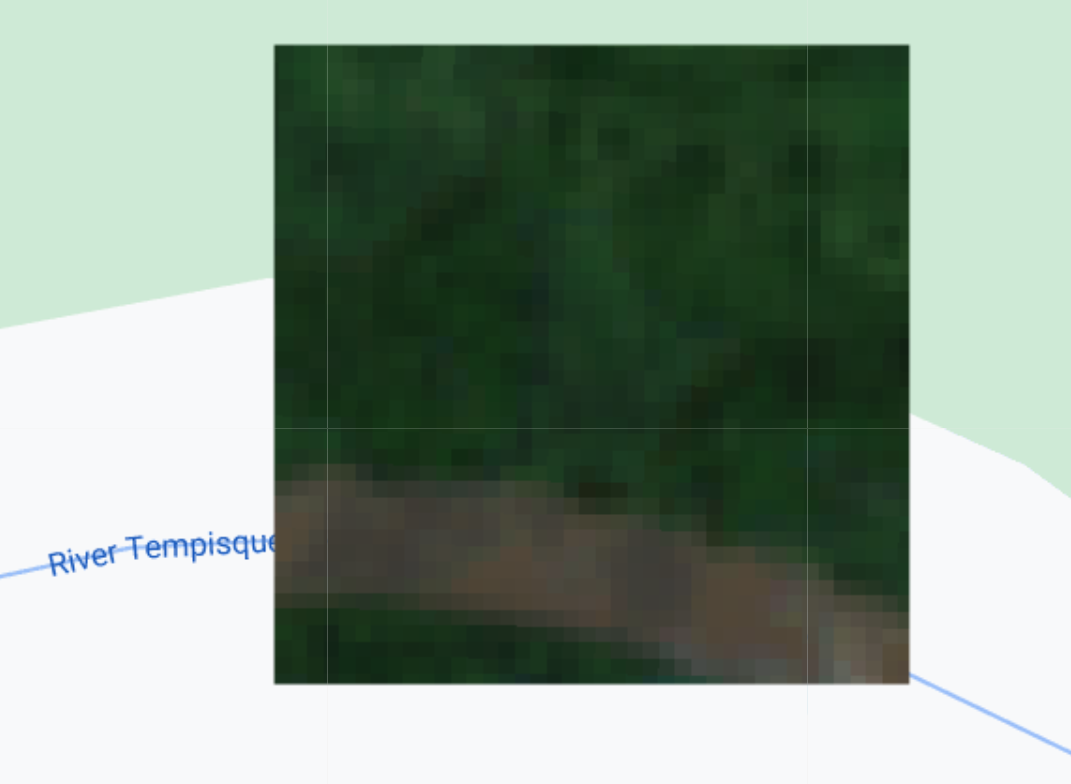

`PV_VI.csv` records monthly from Sentinel-2 data for each grid cell in 2020 (12 month in total), including

* Raw reflectance data from Red, Green, Blue, and Near-Infrared bands (columns `Red`,`Grn`,`Blu`,and `Nir`)
* Popular remote sensing indices such as Enhanced Vegetation Index (`EVI`), Normalized Difference Vegetation Index (`NDVI`), Near-Infrared Reflectance of Vegetation (`NIRv`), and Normalized Difference Water Index (`NDWI`)
* Grid and time information (`Grid` -> index for each grid, to search for its lat and lon, `TimeIndex` combines `Month` and `Year` and serves as a continuous time index over the two years)

`grid_latlon.csv` records the latitude and lontitude for each grid cell. This is used for spatial plotting.

Rubrics:

This assignment has 2 questions with nested sub-questions. Total credit will be 20, which will be further normalized to 25 credits.

#### Q1: Effective Dimensions of Remote Sensing Data

In `PV_VI.csv`, there are eight remote sensing metrics (`Red`,`Grn`,`Blu`,`Nir`,`EVI`,`NDVI`,`NDWI`, and `NIRv`) describing the spatial and temporal variations within the landscape. We can use Principle Components Analysis (PCA) to assess the similarity and differences of all these metrics.

**(a)** Conduct a PCA by treating each remote sensing metric as a dimension (i.e. a column of the input data matrix) and each grid-time combination as an observation (i.e. a row of the input data matrix). Report the inertia/explained variance of the resulting components (8 in total) and interpret the biplot (i.e. loading of each dimension on the first two leading PC). 


In [ ]:
# answer (a) here


**(b)** What about the PCA results for temporal variation of one grid cell (e.g. using grid cell Grid == 800)? What about the PCA results for spatial variation of all grid cell at one time point (e.g. using Month == 4)? Briefly describe the difference of these two PCA results with that from (a)

In [ ]:
# answer (b) here


#### Q2: Clustering and Classification Analysis

We can futher use the remote sensing metrics to get the dominant land cover types. Specifically, we can treat a metric of a given month as a dimension (8 * 12 = 96 dimensions) while treating each grid cell as an observation.

**(a)** Re-arrange the data from `PV_VI.csv` so that each row represents a grid cell, each column represents a dimension (e.g. you need to add dimensions like Red_M01 --> value of Red reflectance from Month 1, and EVI_M12 --> value of EVI from Month 12). Conduct a PCA analysis of the new data matrix and report how much variance will first **two** PC explain


**(b)** Scatter plot the spatial variation of the first two components (i.e. same as the scatter plot from PCA biplot). Cluster them into 2, 3, and 4 groups using Kmeans method. Plot the spatial patterns of the results using the lat and lon information from `grid_latlon.csv` (can simply use scatter plot). Compare to the RGB images upfront and briefly discuss what each cluster likely represents

**(c)** If we know the land cover type of a few grid cells (i.e. some grid cells are labeled), we can use classification algorithms to define land cover types. Assume that Grid 35,36 are Deciduous Forests, Grid 870 and 871 are evergreen forests, and Grid 1760 and 1761 are water body. 

Create a RandomForest Classification using the *original dataframe that has 96 dimensions*. Then predict the land cover type for all grid cells and plot the results

Try again using Support-Vector Machine and plot the results

Qualitatively discuss the accuracy of the results by comparing them with the dry season RGB image shown at the beginning.

----
#### Appendix Data Preparation

In [ ]:
# Sentinel data acquisition from GEE
import ee

try:
    ee.Initialize()
except:
    # need to authenticate with your credential at the first time
    ee.Authenticate()
    ee.Initialize()
#import geemap 
import geemap.eefolium as geemap

# to get day number for each month
from calendar import monthrange


# lat and lon for a random place at Palo Verde National Park, Costa Rica
loc = [10.3450, -85.3705]

# identify a 1km buffer around our Point Of Interest (POI)
poi = ee.Geometry.Point(loc[1],loc[0]).buffer(200)


# get Sentinel data
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask1 = (qa.bitwiseAnd(cloudBitMask).eq(0))
    mask2 = (qa.bitwiseAnd(cirrusBitMask).eq(0))
    mask = mask1.bitwiseAnd(mask2)

    return image.updateMask(mask).divide(10000)



# loop over each month from 2019-2020 to get monthly Sentinel Imagery?
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
years = [2019,2020]
months = range(1,12+1)
for year in years:
    for month in months:
        time_stamp = f'{year:04d}-{month:02d}'
        day_start = 1
        day_end = monthrange(year,month)[1]
        print(year,month,day_start,day_end)
        image =( 
            ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterDate(time_stamp+f'-{day_start:02d}'
                             ,time_stamp+f'-{day_end:02d}')
                  .filterBounds(poi)                      
                  .map(maskS2clouds)
                  .median()
                  .clip(poi.bounds())
                  #.map(lambda img: img.clip(poi.bounds()))

                    )

        out_name = f'./data/Sentinel_PV_{time_stamp}.tif'
        geemap.ee_export_image(image, out_name,scale=10) # 10 meter

In [ ]:
# calculate Red, Grn, Blu, Nir, EVI, NIRv, and NDWI for each month
# combine them into a csv file
# create another data file to record the lat and lon for each grid cell
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
import pandas as pd

df_vi = {
    'Grid' : [],
    'Year' : [],
    'Month' : [],
    'TimeIndex' : [],
    'Red' : [],
    'Grn' : [],
    'Blu' : [],
    'Nir' : [],
    'EVI' : [],
    'NDWI' : [],
    'NDVI' : [],
    'NIRv' : [],    
}

# some functions and constants
evi_func = lambda nir, red, blu: 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blu + 1.)
ndwi_func = lambda grn, nir : (grn - nir) / (grn + nir)  # used for water body instead of wwater content of leaves
ndvi_func = lambda nir, red: (nir - red) / (nir + red)
nirv_func = lambda nir, red: nir * (nir - red) / (nir + red)

# index of relevant band
Iblu, Igrn, Ired, Inir = 1,2,3,7


years = [2020]
months = range(1,12+1)
time_index = 0
for year in years:
    for month in months:
        tif_name = f'./data/Sentinel_PV_{year:04d}-{month:02d}.tif'
        
        src = rasterio.open(tif_name, 'r')
        im = src.read()
        # read image into ndarray

        # transpose the array from (band, row, col) to (row, col, band)
        im = np.transpose(im, [1,2,0])
        
        Red = im[:,:,Ired].ravel()
        Grn = im[:,:,Igrn].ravel()
        Blu = im[:,:,Iblu].ravel()
        Nir = im[:,:,Inir].ravel()
        
        EVI = evi_func(Nir,Red,Blu)
        NDWI = ndwi_func(Grn,Nir)
        NDVI = ndvi_func(Nir,Red)
        NIRv = nirv_func(Nir,Red)
        
        Grid = np.arange(len(Red))
        Month = np.ones_like(Grid) * month
        Year = np.ones_like(Grid) * year
        TimeIndex = np.ones_like(Grid) * time_index
        
        time_index += 1
        
        # append the data into df_vi
        df_vi['Red'].extend(Red)
        df_vi['Grn'].extend(Grn)
        df_vi['Blu'].extend(Blu)
        df_vi['Nir'].extend(Nir)
        df_vi['EVI'].extend(EVI)
        df_vi['NDWI'].extend(NDWI)
        df_vi['NDVI'].extend(NDVI)
        df_vi['NIRv'].extend(NIRv)
        df_vi['Grid'].extend(Grid)
        df_vi['Month'].extend(Month)
        df_vi['Year'].extend(Year)
        df_vi['TimeIndex'].extend(TimeIndex)
        
        
        # close file handle
        src.close()
        
df_vi = pd.DataFrame(df_vi)


df_vi.to_csv('./PV_VI.csv',index=False)

In [ ]:
# get the spatial coordinates of each grid cell
# use the last file
src = rasterio.open(tif_name, 'r')
im = src.read()
# read image into ndarray

# transpose the array from (band, row, col) to (row, col, band)
im = np.transpose(im, [1,2,0])

# transform to cartopy format, left, right, low, up
img_extent = [src.bounds[0],src.bounds[2],src.bounds[1],src.bounds[3]]
print(img_extent)


src.close()

# X axis, from north to south
lat_array = np.linspace(src.bounds[1],src.bounds[3],im.shape[0])
# Y axis, from west to east
lon_array = np.linspace(src.bounds[2],src.bounds[0],im.shape[0])


print(lat_array)
print(lon_array)

grid_lat, grid_lon = np.meshgrid(lat_array,lon_array)

# save the grid lat and lon

df_grid = pd.DataFrame(
    {
        'Grid' : np.arange(len(grid_lat.ravel())),
        'LAT'  : grid_lat.ravel(),
        'LON'  : grid_lon.ravel()
    }
)

df_grid.to_csv('./grid_latlon.csv')
